In [1]:
cd D:\Course\SBRS

D:\Course\SBRS


In [31]:
%load_ext autoreload
%autoreload 2

from src.algoritms import association_rules as ar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import unittest
from tqdm import tqdm 
import time 
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# with open('params.yaml') as conf_file:
#     config = yaml.safe_load(conf_file)

In [33]:
AR = ar.AssociationRules(pruning=50, session_key='session_key', item_key='item_key' )

In [34]:
# !python src/stages/data_load.py --config=params.yaml

In [35]:
# from src.stages.data_load import data_load

# df1 = pd.read_csv(config['data_load']['dataset_xlsx'])
# df1

In [37]:
file_data = 'datasets/onlineretail/online_retail.xlsx'
df = pd.read_csv(file_data)

In [39]:
# df1 = df.drop(['Description','Quantity','UnitPrice','userid','Country'], axis = 1)

In [40]:
# DataFrame для обработки
# df1.rename(columns = {'transactionid' : 'session_key', 'itemid' : 'item_key', 'datetime' : 'time_key'}, inplace = True)

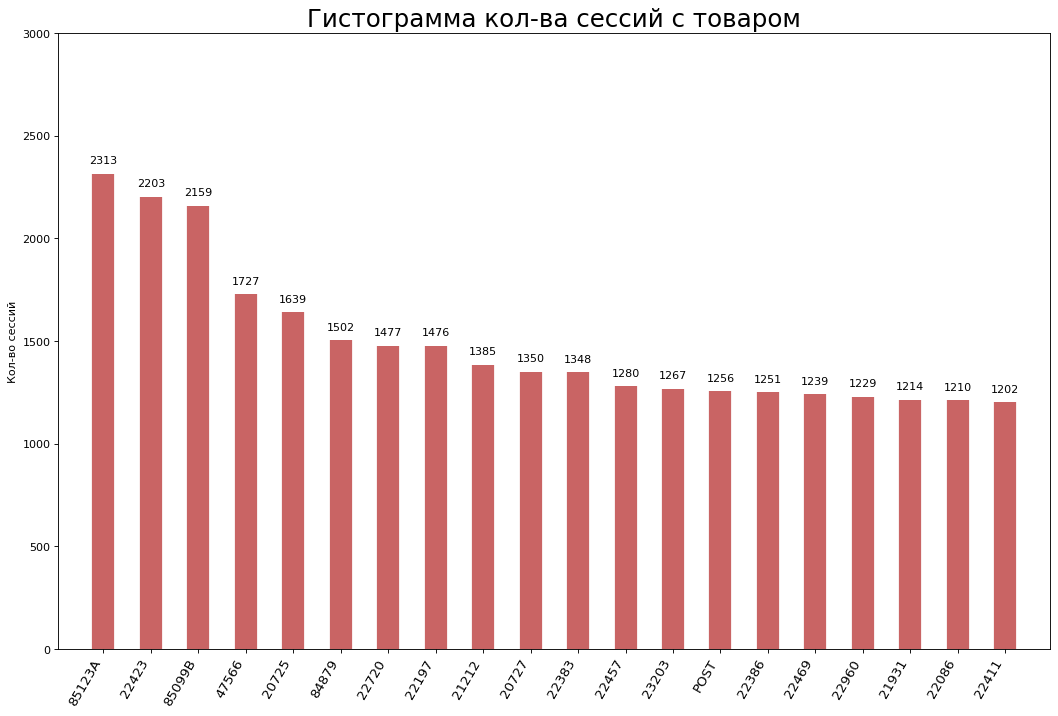

In [41]:
# График кол-ва покупок каждого товара 
def item_hist():
    counts_of_items = df1['item_key'].value_counts()
    plot_df = pd.DataFrame({'item':counts_of_items.index.to_list(), 'counts':counts_of_items.to_list()})
    plot_df = plot_df[plot_df.counts > 1200]

    fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
    ax.vlines(x=plot_df.index, ymin=0, ymax=plot_df.counts, color='firebrick', alpha=0.7, linewidth=20)

    for i, counts in enumerate(plot_df.counts):
        ax.text(i, counts+50, round(counts, 1), horizontalalignment='center')

    ax.set_title('Гистограмма кол-ва сессий с товаром', fontdict={'size':22})
    ax.set(ylabel='Кол-во сессий', ylim=(0, 3000))
    plt.xticks(plot_df.index, plot_df.item, rotation=60, horizontalalignment='right', fontsize=12)

    plt.show()
    
item_hist()

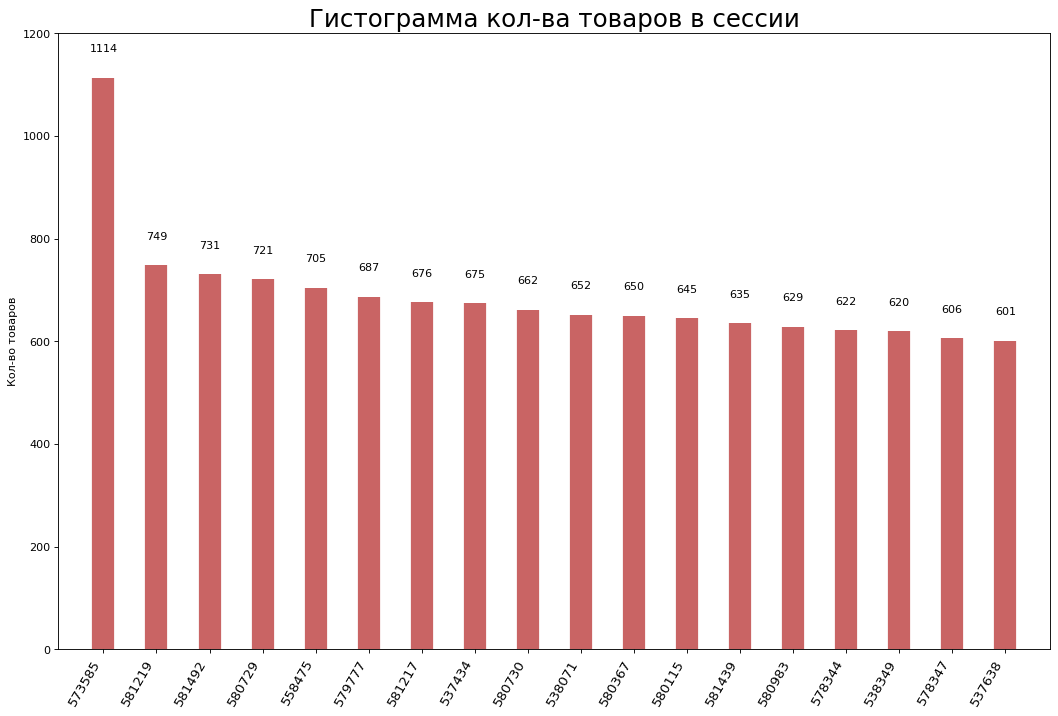

In [42]:
# Гистограмма длинный сессий 
def session_hist():
    counts_of_session = df1['session_key'].value_counts()
    plot_df = pd.DataFrame({'session':counts_of_session.index.to_list(), 'counts':counts_of_session.to_list()})
    plot_df = plot_df[plot_df.counts > 600]

    fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
    ax.vlines(x=plot_df.index, ymin=0, ymax=plot_df.counts, color='firebrick', alpha=0.7, linewidth=20)

    for i, counts in enumerate(plot_df.counts):
        ax.text(i, counts+50, round(counts, 1), horizontalalignment='center')

    ax.set_title('Гистограмма кол-ва товаров в сессии', fontdict={'size':22})
    ax.set(ylabel='Кол-во товаров', ylim=(0, 1200))
    plt.xticks(plot_df.index, plot_df.session, rotation=60, horizontalalignment='right', fontsize=12)

    plt.show()
    
session_hist()


In [43]:
df1

,session_key,item_key,time_key
0,536365,85123A,2010-12-01 08:26:00
1,536365,71053,2010-12-01 08:26:00
2,536365,84406B,2010-12-01 08:26:00
3,536365,84029G,2010-12-01 08:26:00
4,536365,84029E,2010-12-01 08:26:00
...,...,...,...
541904,581587,22613,2011-12-09 12:50:00
541905,581587,22899,2011-12-09 12:50:00
541906,581587,23254,2011-12-09 12:50:00
541907,581587,23255,2011-12-09 12:50:00


In [44]:
# Тренировка улучшенным методом Apriori
AR.fit(df1)

In [45]:
# Генерация сессии для тестирования метрики 
items = df1.item_key.unique()
def generating_test_session():
    sessions = df1.session_key.unique()
    
    random_session = random.choice(sessions)
    items_arr = np.array(df1[df1['session_key']==random_session].item_key)
    return items_arr

In [74]:
# Нахождение ранга элемента сессии
def eval_MRR(predictions, item):
    for i, tuple_ in enumerate(predictions):
        if tuple_[0] == str(item):
            return i + 1
    else:# тут была ошибка: если элемент не первый, то просто выдавалось 0(else был внутри цикла for)
        return 0

In [75]:
# Вывод списка элементов, которые связанны с текущим 
def predict(session):
    global items
    
    if len(session)==1:
        predictions = AR.predict_next('1',session[0],items)
    else:
        for i in range(1,len(session)):
            session_name = str(i)
            AR.predict_next(session_name, session[:i+1], items, skip=True)
        predictions = AR.predict_next(session_name, session[-1], items)
        
    predictions = predictions[predictions>0.655]    
    name = predictions.index.to_list()
    for i in range(len(name)):
        name[i] = str(name[i])
    value = predictions.to_list()
    prd = [*zip(name, value)]
    sort_prd = sorted(prd,key = lambda x : x[1], reverse = True)
    return sort_prd

In [90]:
# Реализация метрики MRR
def MRR(items_arr):
    sum = 0
    len_items_arr = len(items_arr)-1
    if len_items_arr == 0:
        return 0
    else:
        for i in range(0, len_items_arr):
            pred = predict(items_arr[:i+1])
            try:
                if pred == []:
                    return 0
                else:
                    sum += 1/eval_MRR(pred, items_arr[i+1])
            except ZeroDivisionError:
                    sum += 0
    return round(sum / len_items_arr, 4)
test_session = generating_test_session()
print(test_session)
1/MRR(test_session) # Средний номер первой релевантной рекомендации!

['21528' '21669' '22725' '22729' '22627' '21534' '22077' '23167' '22726'
 '23342' '22844']


ZeroDivisionError: float division by zero

In [77]:
# Тестирование 
def unit_tests():    
    testing_session_562564 = ['22487', '20724', '22356', '20723', '20719', '22144', '22141', '22142', '22147',
       '22150', '22149', '22501', '20727', '23209', '20725', '23208', '22557']
    
    testing_session_569998 = ['22573', '22574', '22601', '85066', '21524', '22374', '22727', '22726', '22846',
       '22848', '23247', '21843', '22045', '23545', '23546', '22406', '22831', '20772',
       '35810A', '22629', '23076', 'POST']
    
    assert MRR(testing_session_562564) == 0.2865, f'Expected 0.2865 but return {MRR(testing_session_562564)}'
    assert MRR(testing_session_569998) == 0.119, f'Expected 0.119 but return {MRR(testing_session_569998)}'
    assert MRR([]) == 0, f'Expected 0 but return {MRR([])}' 
    assert MRR([20724]) == 0, f'Expected 0 but return {MRR([20724])}'
    
unit_tests()